In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

## Load Data

In [21]:
##### LOAD TASKS ##### 
tasks = pd.read_csv('tasks.csv', delimiter=';')
data_transfers = pd.read_csv('datatransfers.csv', delimiter=';')

tasks['index'] = tasks['task']
tasks.set_index('index', inplace = True)

tasks["task_type"] = 'Task'
tasks["task_status"] = 'None'

# days between start and end of each task
tasks['interval'] = tasks.end - tasks.start


In [22]:
##### LOAD VMs ##### 
vm_counter = 0
vm_types = pd.read_csv('vmtypes.csv', delimiter=';')
vms = pd.DataFrame()
print(vm_types)

  vm_type  perf  cost  vm_start_time  vm_stop_time
0      1X     1     1              5             1


In [23]:
def calcTimingsForVM(vm_perf, tasks):
    tasks['calc_time'] = (tasks.volume / vm_perf)
    tasks['latest_start'] = (tasks.end - tasks.calc_time)
    tasks['earliest_finish'] = (tasks.start + tasks.calc_time)
    


#leader_vm = vm_types.nlargest(1, 'perf').iloc[0]
#calcTimingsForVM(leader_vm['perf'], tasks)    

In [24]:
print("TASKS:")
print(tasks)
print("""

DATA TRANSFERS:""")
print(data_transfers.head())

TASKS:
          task  start  end  volume task_type task_status  interval
index                                                             
Task 1  Task 1      0    7       4      Task        None         7
Task 2  Task 2      0    8       5      Task        None         8
Task 3  Task 3      2   10       6      Task        None         8
Task 4  Task 4      4   10       2      Task        None         6
Task 5  Task 5      8   20       8      Task        None        12
Task 6  Task 6     10   15       1      Task        None         5
Task 7  Task 7     10   22      10      Task        None        12
Task 8  Task 8     15   25       7      Task        None        10


DATA TRANSFERS:
  source_task target_task  volume
0      Task 1      Task 5     100
1      Task 1      Task 7      20
2      Task 2      Task 7      10
3      Task 3      Task 6     150
4      Task 4      Task 7       5


## Business Logic

In [25]:
def assignToLeader(vm_types, tasks, time, num):
    
    # first find leader and recalculate possible tasks timings
    leader_vm = vm_types.nlargest(1, 'perf').iloc[0]
    calcTimingsForVM(leader_vm['perf'], tasks)   
    
    # next 
    tasks.loc[tasks.task_status == 'None', "possible_start"] = np.maximum(tasks.start, time)
    ttasks = tasks[tasks.task_status == 'None']  # next available tasks to schedule

    ttasks.earliest_finish = ttasks.possible_start + tasks.calc_time
    EFT = ttasks.earliest_finish.min()
    
    tasks.loc[(ttasks.earliest_finish == EFT) & (tasks.task_status == 'None'), ['task_status', 'batch', 'finish_time']] = 'Leader', 'Batch ' + str(num), EFT
    tasks.loc[(ttasks.latest_start < EFT) & (tasks.task_status == 'None'), ['task_status', 'batch', 'finish_time']] = 'Batch', 'Batch ' + str(num), EFT
    #print(EFT)

    return EFT

def retrieveParalellBatches(vm_types, tasks, time):
    batch_num = 0
    while('None' in tasks.task_status.values):
        time = assignToLeader(vm_types, tasks, time, batch_num)
        batch_num += 1
                

In [26]:
retrieveParalellBatches(vm_types, tasks, 0)

tasks = tasks.sort_values(['finish_time', 'task_status', 'start'], ascending = [True, False, True])
print(tasks)

#batch = tasks[tasks.batch == 'Batch 0']
#print(batch)

          task  start  end  volume task_type task_status  interval  calc_time  \
index                                                                           
Task 1  Task 1      0    7       4      Task      Leader         7        4.0   
Task 2  Task 2      0    8       5      Task       Batch         8        5.0   
Task 4  Task 4      4   10       2      Task      Leader         6        2.0   
Task 3  Task 3      2   10       6      Task       Batch         8        6.0   
Task 6  Task 6     10   15       1      Task      Leader         5        1.0   
Task 5  Task 5      8   20       8      Task      Leader        12        8.0   
Task 7  Task 7     10   22      10      Task       Batch        12       10.0   
Task 8  Task 8     15   25       7      Task       Batch        10        7.0   

        latest_start  earliest_finish  possible_start    batch  finish_time  
index                                                                        
Task 1           3.0             

/tmp/ipykernel_724890/1241938935.py:8: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  tasks.loc[tasks.task_status == 'None', "possible_start"] = np.maximum(tasks.start, time)
/tmp/ipykernel_724890/1241938935.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ttasks.earliest_finish = ttasks.possible_start + tasks.calc_time
/tmp/ipykernel_724890/1241938935.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [32]:
def addOffTasks(batch, num):
    off_tasks = {'task': ['Off ' + str(i) for i in range(num)],
                'task_type' : ['Off' for i in range(num)]}
    
    off_tasks_df = pd.DataFrame(off_tasks)
    
    return pd.concat([batch,off_tasks_df], axis=0, ignore_index=True)

def generateVmId(row):
    global vm_counter
    vm_counter = vm_counter + 1
    return 'VM ' + str(vm_counter)

def addNewVmsRandomly(vms, vm_types, num):
    random_types = vm_types.sample(num, replace = True)
    random_types['vm_status'] = 'open'
    random_types['vm_id'] = random_types.apply(lambda x: generateVmId(x), axis=1)  
    
    return pd.concat([vms, random_types], axis=0, ignore_index=True)

#batch = addOffTasks(batch, 10)

#vms = addNewVmsRandomly(vms, vm_types, 5)

def clearTasks(batch):
    return batch[batch.task_type != 'Off']

def getActiveVms(vms):
    return vms[vms.vm_status == 'active']

def prepareVmMatchings(batch, vms, additional_vms_num = 0):
    # first remove old temp tasks and not started vms
    if not batch.empty:
        batch = clearTasks(batch)
    if not vms.empty:
        vms = getActiveVms(vms)
    
    diff = len(batch) - len(vms)
    if diff > 0:
        vms = addNewVmsRandomly(vms, vm_types, diff)
    elif diff < 0:
        batch = addOffTasks(batch, -diff)
        
    # add additional vms and tasks for more optimization options    
    if additional_vms_num > 0:
        vms = addNewVmsRandomly(vms, vm_types, additional_vms_num)
        batch = addOffTasks(batch, additional_vms_num)

    #pair all    
    vms['key'] = 1
    batch['key'] = 1
    matching = pd.merge(batch, vms, on = 'key', suffixes=("_task", "_vm"))
    
    #print(matching)
    
    return matching
        

#matchings = prepareVmMatchings(batch, vms, 2)
#print(matchings)
    

In [33]:
import random
import math

current_time = 0

def calcVmAllocationCost(row):
    
    # if new vm
    if(row.vm_status == 'open'):
        possible_vm_start = current_time  # can start now
        previous_vm_cost = 0              # no waiting costs
    else:
        possible_vm_start = tasks[tasks.assigned_vm == row.vm_id].allocation_end.max()  # can start once previous tasks are finished
        if(current_time > possible_vm_start):
            previous_vm_cost = (current_time - possible_vm_start) * row.cost            # pay for idle time between previous task and now
        else:
            previous_vm_cost = 0
    
    if row.task_type == 'Off':
        runtime = row.vm_stop_time                    #data transfer time here?
        possible_task_start = current_time
    else:
        runtime = math.ceil(row.volume / row.perf) 
        if(row.vm_status == 'open'):
            runtime = runtime + row.vm_start_time     # add startup time
        possible_task_start = row.start               # possibly check if can start earlier, when all previous tasks are finished
        
    expected_start = max(possible_vm_start, possible_task_start)    # TODO: vms can be started before task is ready (i.e. substract startup time, but not cost)
    expected_end = expected_start + runtime
    
    if expected_end > row.end:
        allocation_cost = 10000000000 # can't execute task
    else:    
        allocation_cost = runtime * row.cost
        
    return allocation_cost, expected_start, expected_end

def calcAllocationCosts(matchings):
    matchings[['allocation_cost', 'allocation_start', 'allocation_end']] = matchings.apply(lambda x: calcVmAllocationCost(x), axis=1, result_type='expand')  
    

In [34]:
def calcPairing(row, task_list, vm_list):
    if row.task in task_list and row.vm_id in vm_list:
        task_list.remove(row.task)
        vm_list.remove(row.vm_id)
        return 1
    else:
        return 0
   
#deprecated 
def simulatePairings(matchings):
#    g = matchings.groupby(by = 'task')
#    return matchings.loc[g["allocation_cost"].idxmax()]
    task_list = list(matchings.task.unique())
    vm_list = list(matchings.vm_id.unique())
    #print(task_list)
    #print(vm_list)
    matchings['pairing'] = matchings.apply(lambda x: calcPairing(x, task_list, vm_list), axis=1)  
    pairings = matchings[matchings.pairing == 1]
    
    return pairings


from hungarian_algorithm import algorithm

def calculateMinCostPairings(matchings):
    unique_tasks = list(matchings.task.unique())
    cost_matrix = {}
    for task_name in unique_tasks:
        task_pairs = matchings[matchings.task == task_name][['vm_id', 'allocation_cost']]
        task_pairs.set_index('vm_id')
        pair_data = task_pairs.to_dict('split')['data']
        task_dict = {}
        for pair in pair_data:
            task_dict[pair[0]] = pair[1]
        cost_matrix[task_name] = task_dict

    print(cost_matrix)
    res = algorithm.find_matching(cost_matrix, matching_type = 'min', return_type = 'list' )
    matchings['pairing'] = 0
    for task_res in res:
        matchings.loc[(matchings.task == task_res[0][0]) & (matchings.vm_id == task_res[0][1]), 'pairing'] = 1
    
    pairings = matchings[matchings.pairing == 1]
    
    return pairings

In [35]:
def applyPairings(pairings):
    
    global vms
    global tasks
    
    vms_off = pairings[(pairings.vm_status == 'active') & (pairings.task_type == 'Off')]
    vms_off = vms_off[['vm_id', 'vm_status', 'allocation_end']]
    vms_off['vm_status'] = 'shutdown'
    vms_off['index'] = vms_off['vm_id']
    vms_off.rename(columns={'allocation_end':'vm_end'}, inplace=True)
    vms_off.set_index('index', inplace = True)
    vms = vms_off.combine_first(vms)
    
    vms_cancel = pairings[(pairings.vm_status == 'open') & (pairings.task_type == 'Off')]  # do nothing, these vms weren't added to vms df
    
    vms_activate = pairings[(pairings.vm_status == 'open') & (pairings.task_type == 'Task')]
    vms_activate = vms_activate[['vm_id', 'vm_status', 'vm_type', 'perf', 'allocation_start']]
    vms_activate['vm_status'] = 'active'
    vms_activate['index'] = vms_activate['vm_id']
    vms_activate.rename(columns={'allocation_start':'vm_start'}, inplace=True)
    vms_activate.set_index('index', inplace = True)
    vms = vms_activate.combine_first(vms)
   
    vms_reuse = pairings[(pairings.vm_status == 'active') & (pairings.task_type == 'Task')] # do nothing, they just remain active

    
    assigned_tasks = pairings[pairings.task_type == 'Task']
    assigned_tasks = assigned_tasks[['task', 'allocation_start', 'allocation_end', 'vm_id']]
    assigned_tasks.rename(columns={'vm_id':'assigned_vm'}, inplace=True)
    assigned_tasks['index'] = assigned_tasks['task']
    assigned_tasks.set_index('index', inplace = True)
    tasks = assigned_tasks.combine_first(tasks)
    
    #print("VMS:")
    #print(vms)
    
    #print("TASKS:")
    #print(tasks)
    
#calcAllocationCosts(matchings)
#pairings = simulatePairings(matchings)
#print(pairings[["task", 'volume', "vm_id", "vm_status", "allocation_cost", 'allocation_start', 'allocation_end', "pairing"]])
#applyPairings(pairings)
#print(pairings)

In [36]:
def scheduleBatch(batch_num):
    print(batch_num)
    batch = tasks[tasks.batch == batch_num]
    matchings = prepareVmMatchings(batch, vms, 2)
    #print(matchings.columns)
    calcAllocationCosts(matchings)
    #pairings = simulatePairings(matchings)
    pairings = calculateMinCostPairings(matchings)
    print(pairings[["task", 'volume', "vm_id", "allocation_cost", 'allocation_start', 'allocation_end', "pairing"]])
    applyPairings(pairings)

batches = list(tasks.batch.unique())

for batch_num in batches:
    scheduleBatch(batch_num)
    
print("VMS:")
print(vms)
    
print("TASKS:")
print(tasks)

Batch 0
{'Task 1': {'VM 3': 10000000000, 'VM 4': 10000000000, 'VM 5': 10000000000, 'VM 6': 10000000000}, 'Task 2': {'VM 3': 10000000000, 'VM 4': 10000000000, 'VM 5': 10000000000, 'VM 6': 10000000000}, 'Off 0': {'VM 3': 1, 'VM 4': 1, 'VM 5': 1, 'VM 6': 1}, 'Off 1': {'VM 3': 1, 'VM 4': 1, 'VM 5': 1, 'VM 6': 1}}
      task  volume vm_id  allocation_cost  allocation_start  allocation_end  \
3   Task 1     4.0  VM 6      10000000000                 0               9   
6   Task 2     5.0  VM 5      10000000000                 0              10   
8    Off 0     NaN  VM 3                1                 0               1   
13   Off 1     NaN  VM 4                1                 0               1   

    pairing  
3         1  
6         1  
8         1  
13        1  
Batch 1
{'Task 3': {'VM 6': 10000000000.0, 'VM 5': 10000000000.0, 'VM 7': 10000000000.0, 'VM 8': 10000000000.0}, 'Task 4': {'VM 6': 10000000000.0, 'VM 5': 10000000000.0, 'VM 7': 10000000000.0, 'VM 8': 10000000000.0}, 'Off 0

KeyboardInterrupt: 

In [ ]:
scheduleBatch('Batch 0')
    
print("VMS:")
print(vms)
    
print("TASKS:")
print(tasks)

Batch 0
{'Task 1': {'VM 10': -100000.0, 'VM 11': -100000.0, 'VM 7': -100000.0, 'VM 12': 4170.0, 'VM 13': 9957.0}, 'Task 2': {'VM 10': -100000.0, 'VM 11': -100000.0, 'VM 7': -100000.0, 'VM 12': 4432.0, 'VM 13': 5873.0}, 'Off 0': {'VM 10': 9444.0, 'VM 11': 7827.0, 'VM 7': 7209.0, 'VM 12': 907.0, 'VM 13': 7442.0}, 'Off 1': {'VM 10': 7995.0, 'VM 11': 9988.0, 'VM 7': 2918.0, 'VM 12': 4326.0, 'VM 13': 3792.0}}


In [30]:
scheduleBatch('Batch 1')
    
print("VMS:")
print(vms)
    
print("TASKS:")
print(tasks)

Batch 1
{'Task 3': {'VM 3': 3211.0, 'VM 4': -100000.0, 'VM 5': 5467.0, 'VM 6': 1318.0}, 'Task 4': {'VM 3': 7818.0, 'VM 4': 56.0, 'VM 5': 595.0, 'VM 6': 6615.0}, 'Off 0': {'VM 3': 8805.0, 'VM 4': 1527.0, 'VM 5': 5959.0, 'VM 6': 5796.0}, 'Off 1': {'VM 3': 3996.0, 'VM 4': 5062.0, 'VM 5': 7682.0, 'VM 6': 9801.0}}
      task  volume vm_id  allocation_cost  allocation_start  allocation_end  \
1   Task 3     6.0  VM 4        -100000.0               5.0            11.0   
6   Task 4     2.0  VM 5            595.0               4.0             6.0   
11   Off 0     NaN  VM 6           5796.0               0.0             0.0   
12   Off 1     NaN  VM 3           3996.0               4.0             4.0   

    pairing  
1         1  
6         1  
11        1  
12        1  
VMS:
       perf type  vm_end vm_id  vm_start vm_status
index                                             
VM 3      1   1X     4.0  VM 3       0.0  shutdown
VM 4      1   1X     NaN  VM 4       0.0    active
VM 5      1   

In [31]:
scheduleBatch('Batch 3')
    
print("VMS:")
print(vms)
    
print("TASKS:")
print(tasks)

Batch 3
{'Task 5': {'VM 4': 900.0, 'VM 5': 2639.0, 'VM 7': 8867.0, 'VM 8': 1336.0, 'VM 9': 6187.0}, 'Task 7': {'VM 4': 5910.0, 'VM 5': 4438.0, 'VM 7': 937.0, 'VM 8': 7132.0, 'VM 9': 3279.0}, 'Task 8': {'VM 4': 2720.0, 'VM 5': 3302.0, 'VM 7': 4336.0, 'VM 8': 8873.0, 'VM 9': 617.0}, 'Off 0': {'VM 4': 1407.0, 'VM 5': 3650.0, 'VM 7': 674.0, 'VM 8': 6891.0, 'VM 9': 3338.0}, 'Off 1': {'VM 4': 2958.0, 'VM 5': 4070.0, 'VM 7': 8428.0, 'VM 8': 1791.0, 'VM 9': 748.0}}
      task  volume vm_id  allocation_cost  allocation_start  allocation_end  \
1   Task 5     8.0  VM 5           2639.0               8.0            16.0   
7   Task 7    10.0  VM 7            937.0              10.0            20.0   
14  Task 8     7.0  VM 9            617.0              15.0            22.0   
15   Off 0     NaN  VM 4           1407.0              11.0            11.0   
23   Off 1     NaN  VM 8           1791.0               0.0             0.0   

    pairing  
1         1  
7         1  
14        1  
15     

## Hungarian Algorithm Test

In [3]:
from munkres import Munkres, print_matrix, DISALLOWED

matrix = [[5, 9, DISALLOWED],
          [10, DISALLOWED, 2],
          [8, 7, 4]]

matrix = [[9, 10, 10, 10, 10],
          [11, 12, 12, 12, 12],
          [8, 9, 9, 9, 9],
          [1, 1, 1, 1, 1]]



m = Munkres()
indexes = m.compute(matrix)
print_matrix(matrix, msg='Lowest cost through this matrix:')

total = 0
for row, column in indexes:
    value = matrix[row][column]
    total += value
    print(f'({row}, {column}) -> {value}')
print(f'total cost: {total}')


Lowest cost through this matrix:
[ 9, 10, 10, 10, 10]
[11, 12, 12, 12, 12]
[ 8,  9,  9,  9,  9]
[ 1,  1,  1,  1,  1]
(0, 0) -> 9
(1, 4) -> 12
(2, 3) -> 9
(3, 1) -> 1
total cost: 31


In [ ]:
from hungarian_algorithm import algorithm

H = {
'A': { '#191': 22, '#122': 14, '#173': 120, '#121': 21, '#128': 4, '#104': 51 },
'B': { '#191': 19, '#122': 12, '#173': 172, '#121': 21, '#128': 28, '#104': 43 },
'C': { '#191': 161, '#122': 122, '#173': 2, '#121': 50, '#128': 128, '#104': 39 },
'D': { '#191': 19, '#122': 22, '#173': 90, '#121': 11, '#128': 28, '#104': 4 },
'E': { '#191': 1, '#122': 30, '#173': 113, '#121': 14, '#128': 28, '#104': 86 },
'F': { '#191': 60, '#122': 70, '#173': 170, '#121': 28, '#128': 68, '#104': 104 },
}

H = {
'A': { '#191': 5, '#122': 5, '#173': 5},
'B': { '#191': 6, '#122': 6, '#173': 6},
'C': { '#191': 0.01, '#122': 0.01, '#173': 0}
}



H = {'Task 5': {'VM 3': 9.0, 'VM 9': 10.0, 'VM 10': 10.0, 'VM 11': 10.0, 'VM 12': 10.0},
     'Task 7': {'VM 3': 11.0, 'VM 9': 12.0, 'VM 10': 12.0, 'VM 11': 12.0, 'VM 12': 12.0},
     'Task 8': {'VM 3': 8.0, 'VM 9': 9.0, 'VM 10': 9.0, 'VM 11': 9.0, 'VM 12': 9.0},
     'Off 0': {'VM 3': 1.0, 'VM 9': 1.0, 'VM 10': 1.0, 'VM 11': 1.0, 'VM 12': 1.0}, 
     'Off 1': {'VM 3': 1.0, 'VM 9': 1.0, 'VM 10': 1.0, 'VM 11': 1.0, 'VM 12': 1.0}}

res = algorithm.find_matching(H, matching_type = 'min', return_type = 'list' )

print(res)

In [59]:
def calculateMinCostPairings(matchings):
    unique_tasks = list(matchings.task.unique())
    cost_matrix = {}
    for task_name in unique_tasks:
        task_pairs = matchings[matchings.task == task_name][['vm_id', 'allocation_cost']]
        task_pairs.set_index('vm_id')
        pair_data = task_pairs.to_dict('split')['data']
        task_dict = {}
        for pair in pair_data:
            task_dict[pair[0]] = pair[1]
        cost_matrix[task_name] = task_dict

    print(cost_matrix)
    res = algorithm.find_matching(cost_matrix, matching_type = 'min', return_type = 'list' )
    matchings['pairing'] = 0
    for task_res in res:
        matchings.loc[(matchings.task == task_res[0][0]) & (matchings.vm_id == task_res[0][1]), 'pairing'] = 1
    
    return matchings

test_batch = tasks[tasks.batch == 0]
test_matching = prepareVmMatchings(test_batch, vms, 2)
calcAllocationCosts(test_matching)

test_matching = test_matching[['task', 'vm_id', 'allocation_cost']]
print(test_matching)

res = calculateMinCostPairings(test_matching)
print(res)

    task  vm_id  allocation_cost
0  Off 0  VM 55             5884
1  Off 0  VM 56             4148
2  Off 1  VM 55             6295
3  Off 1  VM 56               47
{'Off 0': {'VM 55': 5884, 'VM 56': 4148}, 'Off 1': {'VM 55': 6295, 'VM 56': 47}}
    task  vm_id  allocation_cost  pairing
0  Off 0  VM 55             5884        1
1  Off 0  VM 56             4148        0
2  Off 1  VM 55             6295        0
3  Off 1  VM 56               47        1


## Plot Tasks

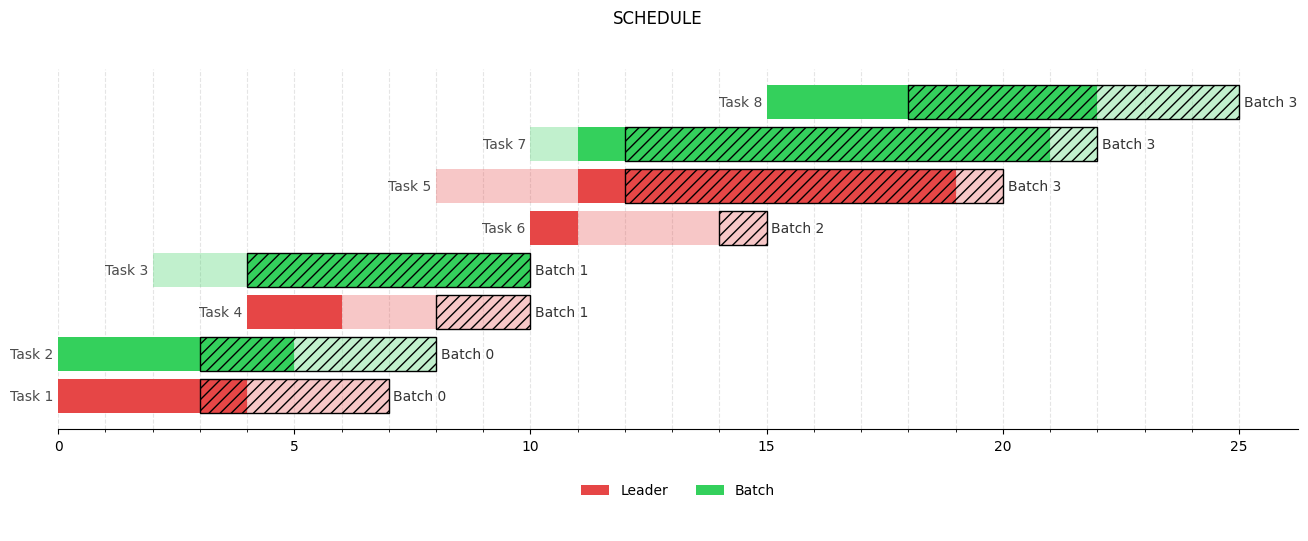

In [29]:
# create a column with the color for each department
def color(row):
    c_dict = {'Leader':'#E64646', 'CPU 2':'#E69646', 'Batch':'#34D05C', 'CPU 4':'#34D0C3', 'CPU 5':'#3475D0', 'None' : '#000000'}
    return c_dict[row['status']]

tasks['color'] = tasks.apply(color, axis=1)



##### PLOT #####
fig, (ax, ax1) = plt.subplots(2, figsize=(16,6), gridspec_kw={'height_ratios':[6, 1]})

# bars

#ax.barh(tasks.Task, tasks.calc_time, left=tasks.LST, color=tasks.color, fill=False, hatch='---')
ax.barh(tasks.task, tasks.interval, left=tasks.start, color=tasks.color, alpha=0.3)
ax.barh(tasks.task, tasks.calc_time, left=tasks.possible_start, color=tasks.color)
#ax.barh(tasks.Task, tasks.calc_time, left=tasks.start_num, color=tasks.color, fill=False)
ax.barh(tasks.task, tasks.calc_time, left=tasks.latest_start, color=tasks.color, fill=False, hatch='///')

rownum = 0
for index, row in tasks.iterrows():
    ax.text(row.end+0.1, rownum, row.batch, va='center', alpha=0.8)
    ax.text(row.start-0.1, rownum, row.task, va='center', ha='right', alpha=0.7)
    rownum += 1


# grid lines
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed', alpha=0.2, which='both')

# ticks
xticks = np.arange(0, tasks.end.max()+1, 5)
xticks_labels = pd.date_range(0, end=tasks.end.max()).strftime("%m/%d")
xticks_minor = np.arange(0, tasks.end.max()+1, 1)
ax.set_xticks(xticks)
ax.set_xticks(xticks_minor, minor=True)
ax.set_yticks([])

# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['top'].set_visible(False)

plt.suptitle('SCHEDULE')

##### LEGENDS #####
legend_elements = [Patch(facecolor='#E64646', label='Leader'),
                   Patch(facecolor='#34D05C', label='Batch')]

ax1.legend(handles=legend_elements, loc='upper center', ncol=5, frameon=False)

# clean second axis
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_xticks([])
ax1.set_yticks([])

plt.show()